In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.ensemble import VotingRegressor, BaggingRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Indent/'

x1_train = pd.read_csv(path+'x1_indent_train.csv')
x2_train = pd.read_csv(path+'x2_indent_train.csv')
f1_train = pd.read_csv(path+'f_indent_train.csv')
f1_test = pd.read_csv(path+'f_indent_test.csv')
x1_test = pd.read_csv(path+'x1_indent_test.csv')
x2_test = pd.read_csv(path+'x2_indent_test.csv')
print(len(x1_train),len(x1_test),len(f1_train),len(f1_test))
X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train),axis=1),columns = ['p1','p2'])
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test),axis=1),columns = ['p1','p2'])
X_train.head()

135869 38801 135869 38801


,p1,p2
0,-0.0000,-0.0000
1,-0.0159,-0.0000
2,-0.0159,0.0171
3,-0.0159,0.0171
4,-0.0000,0.0329


In [3]:
from scipy import *
from scipy.linalg import norm, pinv
import math
 
from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8
        self.W = np.random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**3
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = np.random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
         
        #print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y

In [4]:
def get_results(t,m):
    l1 = len(X_train)
    l2 = len(X_test)
    x_train = [[0 for _ in range(m*2)] for _ in range(l1-t*(m-1))]
    x_test = [[0 for _ in range(m*2)] for _ in range(l2-t*(m-1))]

    for i in range(l1-t*(m-1)):
        for j in range(m):
            x_train[i][j]=X_train.iloc[t*(m-1)+i-2*j,0]
            x_train[i][j+m]=X_train.iloc[t*(m-1)+i-2*j,1]

    y_train = f1_train.iloc[t*(m-1):]

    for i in range(l2-t*(m-1)):
        for j in range(m):
            x_test[i][j]=X_test.iloc[t*(m-1)+i-2*j,0]
            x_test[i][j+m]=X_test.iloc[t*(m-1)+i-2*j,1]
    y_test = f1_test.iloc[t*(m-1):]
    x_train,x_test = np.array(x_train),np.array(x_test)
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    '''
    importances = rf.feature_importances_
    plt.figure(figsize=(20,5))
    x_plot = ['x1(n{})'.format(-i) for i in range(0,m*t,t)] + ['x2(n{})'.format(-i) for i in range(0,m*t,t)]
    plt.plot(x_plot,importances, label = 'Importance Plot')
    plt.legend()
    plt.xlabel('Feature')
    plt.ylabel('Feature importance')
    plt.title('Importance plot for random forest')
    plt.show()'''
    
    # RBF MODEL
    rbf = RBF(2*m, 100, 1)
    t1 = datetime.now()
    rbf.train(x_train, y_train)
    t2 = datetime.now()
    
    print('\n\nTime taken by RBF Model: ',t2-t1)
    y1_pred = rbf.test(x_test)
    y2 = y1_pred
    print('Root mean square error of RBF Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error5 = []
    for i in range(len(y_test)):
        error5.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error5))
    print('Maximum Error =',max(error5))
    error6 = sorted(error5)
    print('Median Value of Error =',error6[len(error5)//2])
    
    
    # SVR MODEL
    t1 = datetime.now()
    clf = SVR()
    clf.fit(x_train,y_train)
    t2 = datetime.now()

    print('\n\nTime taken by SVR Model: ',t2-t1)
    y1_pred = clf.predict(x_test)
    y4 = y1_pred
    print('Root mean square error of SVR Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error7 = []
    for i in range(len(y_test)):
        error7.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error7))
    print('Maximum Error =',max(error7))
    error8 = sorted(error7)
    print('Median Value of Error =',error8[len(error8)//2])
    
    # COMPARISON
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y2[:6000], label = 'RBF')
    plt.plot(list(range(6000)),y4[:6000], label = 'SVR')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    plt.plot(list(range(len(y1_pred))),error5, label = 'Error of RBF Model')
    plt.plot(list(range(len(y1_pred))),error, label = 'Error of Random Forest')
    plt.plot(list(range(len(y1_pred))),error7, label = 'Error of SVR Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    # closer view at initial points
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error7[:6000], label = 'SVR Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    return x_train,x_test,y_train,y_test

Time taken by Random Forest 0:08:20.928151
Root Mean Squared error of Random Forest 0.05160702099234465
Minimum Error = 5.28571428581176e-07
Maximum Error = 0.9773759999999978
Median Value of Error = 0.01899391861471894


Time taken by RBF Model:  0:02:18.207070
Root mean square error of RBF Model:  0.05795006894057802
Minimum Error = [6.94909505e-07]
Maximum Error = [0.94555074]
Median Value of Error = [0.01894839]


Time taken by SVR Model:  0:03:15.187603
Root mean square error of SVR Model:  0.06352980489953057
Minimum Error = 4.4467228260680614e-07
Maximum Error = 0.898980998203398
Median Value of Error = 0.03553012139251421


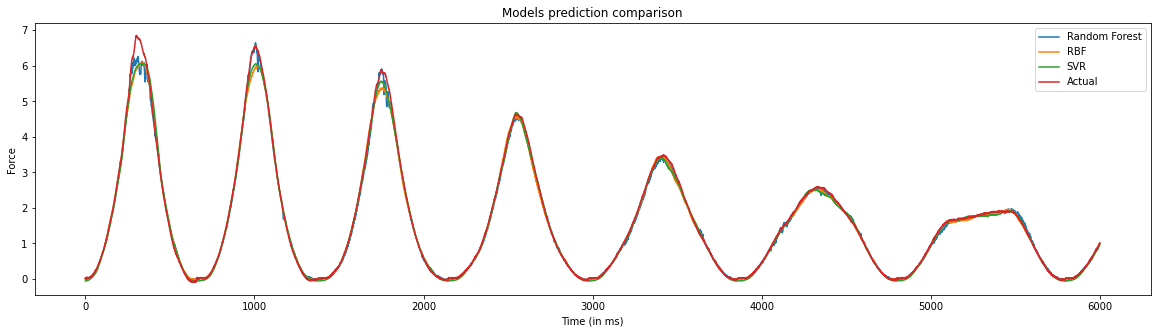

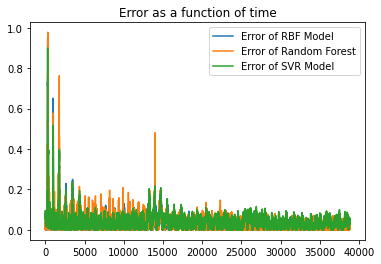

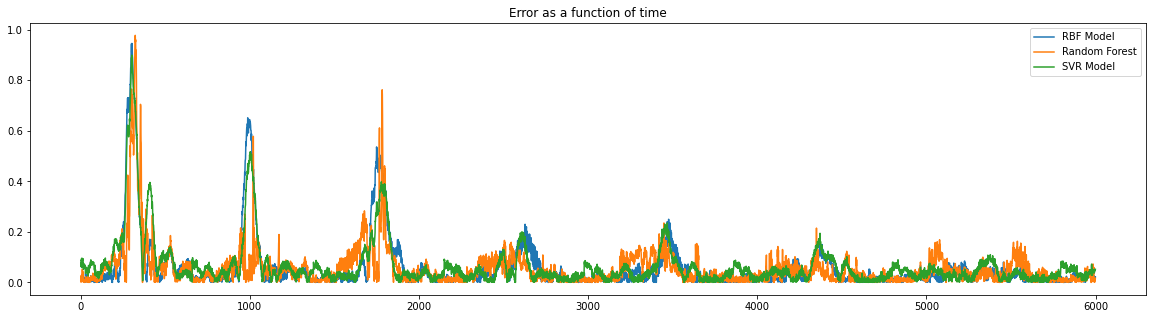

In [5]:
x_train,x_test,y_train,y_test = get_results(t=3, m=2)

In [6]:
print(x_train.shape,x_test.shape)

(135866, 4) (38798, 4)


In [7]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
t1 = datetime.now()
cat.fit(x_train,y_train)
t2 = datetime.now()

Learning rate set to 0.088963
0:	learn: 0.8207594	total: 276ms	remaining: 4m 35s
1:	learn: 0.7519279	total: 283ms	remaining: 2m 21s
2:	learn: 0.6895162	total: 293ms	remaining: 1m 37s
3:	learn: 0.6323818	total: 301ms	remaining: 1m 14s
4:	learn: 0.5805274	total: 310ms	remaining: 1m 1s
5:	learn: 0.5324877	total: 316ms	remaining: 52.3s
6:	learn: 0.4892163	total: 321ms	remaining: 45.6s
7:	learn: 0.4496251	total: 327ms	remaining: 40.6s
8:	learn: 0.4138754	total: 335ms	remaining: 36.9s
9:	learn: 0.3810200	total: 342ms	remaining: 33.9s
10:	learn: 0.3507001	total: 348ms	remaining: 31.3s
11:	learn: 0.3232701	total: 361ms	remaining: 29.7s
12:	learn: 0.2983954	total: 373ms	remaining: 28.3s
13:	learn: 0.2757158	total: 381ms	remaining: 26.8s
14:	learn: 0.2551822	total: 391ms	remaining: 25.7s
15:	learn: 0.2361490	total: 413ms	remaining: 25.4s
16:	learn: 0.2190274	total: 419ms	remaining: 24.2s
17:	learn: 0.2034776	total: 430ms	remaining: 23.5s
18:	learn: 0.1890895	total: 437ms	remaining: 22.6s
19:	lea

In [8]:
print('Time taken by CATBOOST Model: ',t2-t1)
y1_pred = cat.predict(x_test)
y4 = y1_pred
print('Root mean square error of CATBOOST Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
error7 = []
for i in range(len(y_test)):
    error7.append(abs(y1_pred[i]-y_test.iloc[i,0]))
error8 = sorted(error7)
print('Minimum Error =', error8[0])
print('Maximum Error =',error8[-1])

print('Median Value of Error =',error8[len(error8)//2])

Time taken by CATBOOST Model:  0:00:17.051824
Root mean square error of CATBOOST Model:  0.060964208345212066
Minimum Error = 5.165147274333037e-07
Maximum Error = 0.9006888343376609
Median Value of Error = 0.02465772074502276


# Only on present data

Time taken by Random Forest 0:00:54.461159
Root Mean Squared error of Random Forest 0.06788678644306557
Minimum Error = 1.9999999998354667e-06
Maximum Error = 1.1975130000000007
Median Value of Error = 0.028822000000001236


Time taken by RBF Model:  0:03:53.068588
Root mean square error of RBF Model:  0.07551015286203284
Minimum Error = [4.46774039e-07]
Maximum Error = [1.02876002]
Median Value of Error = [0.02896355]


Time taken by SVR Model:  0:02:29.480988
Root mean square error of SVR Model:  0.07447645984424293
Minimum Error = 5.764856426671017e-07
Maximum Error = 0.9009891433997614
Median Value of Error = 0.04580222780086457


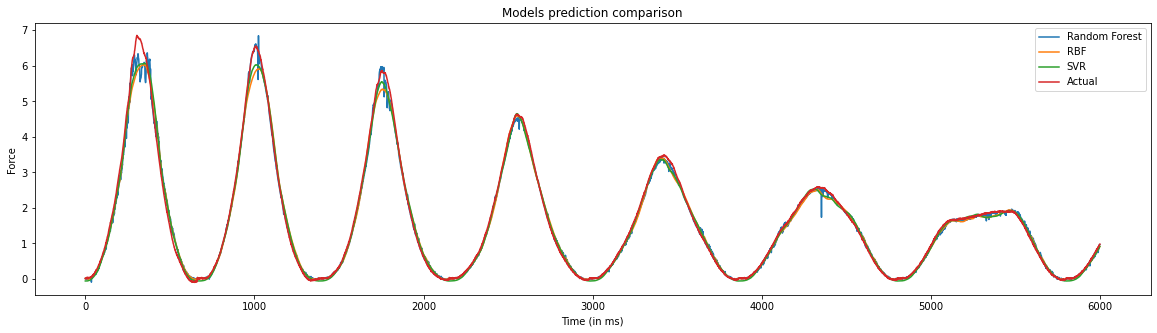

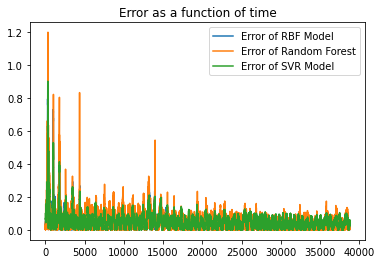

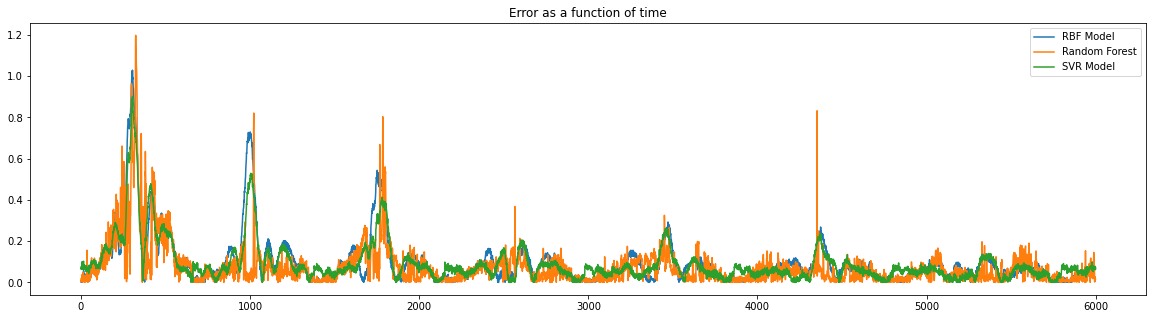

In [5]:
x_train,x_test,y_train,y_test = get_results(t=1, m=1)

In [6]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(135869, 2) (38801, 2) (135869, 1) (38801, 1)


In [8]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
t1 = datetime.now()
cat.fit(x_train,y_train)
t2 = datetime.now()

Learning rate set to 0.088964
0:	learn: 0.8204461	total: 71.5ms	remaining: 1m 11s
1:	learn: 0.7519403	total: 80.8ms	remaining: 40.3s
2:	learn: 0.6889570	total: 87.2ms	remaining: 29s
3:	learn: 0.6322476	total: 94.9ms	remaining: 23.6s
4:	learn: 0.5800837	total: 103ms	remaining: 20.6s
5:	learn: 0.5329858	total: 121ms	remaining: 20s
6:	learn: 0.4895318	total: 134ms	remaining: 19.1s
7:	learn: 0.4500841	total: 150ms	remaining: 18.6s
8:	learn: 0.4136519	total: 164ms	remaining: 18.1s
9:	learn: 0.3808531	total: 190ms	remaining: 18.8s
10:	learn: 0.3506809	total: 216ms	remaining: 19.4s
11:	learn: 0.3231237	total: 226ms	remaining: 18.6s
12:	learn: 0.2981192	total: 233ms	remaining: 17.7s
13:	learn: 0.2755150	total: 247ms	remaining: 17.4s
14:	learn: 0.2544655	total: 286ms	remaining: 18.8s
15:	learn: 0.2353814	total: 308ms	remaining: 18.9s
16:	learn: 0.2182945	total: 319ms	remaining: 18.5s
17:	learn: 0.2025254	total: 325ms	remaining: 17.7s
18:	learn: 0.1881061	total: 331ms	remaining: 17.1s
19:	learn:

In [9]:
print('Time taken by CATBOOST Model: ',t2-t1)
y1_pred = cat.predict(x_test)
y4 = y1_pred
print('Root mean square error of CATBOOST Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
error7 = []
for i in range(len(y_test)):
    error7.append(abs(y1_pred[i]-y_test.iloc[i,0]))
error8 = sorted(error7)
print('Minimum Error =', error8[0])
print('Maximum Error =',error8[-1])

print('Median Value of Error =',error8[len(error8)//2])

Time taken by CATBOOST Model:  0:00:14.123959
Root mean square error of CATBOOST Model:  0.06577763647847414
Minimum Error = 8.339364882259392e-07
Maximum Error = 0.8985052477420012
Median Value of Error = 0.028101390955470484
